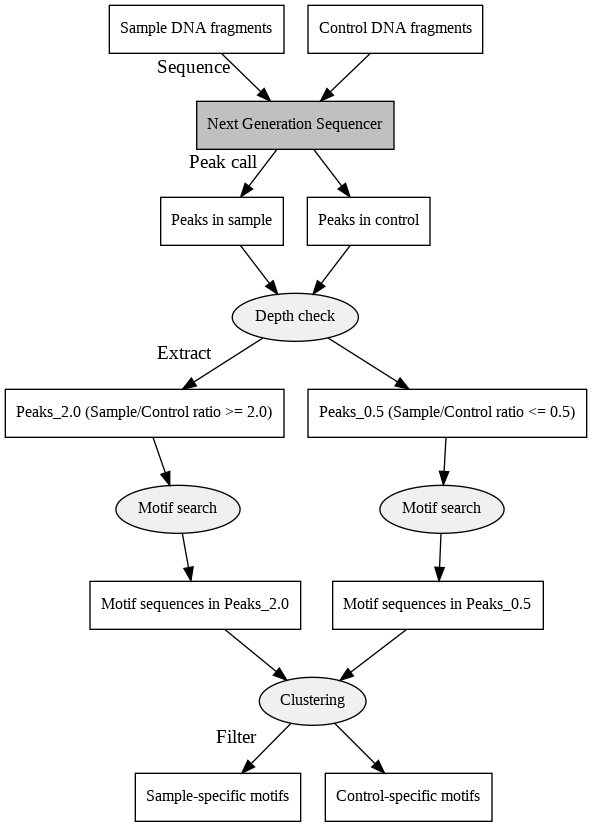

In [54]:
#@title Visualize pipeline
from graphviz import Digraph
from graphviz import Source
from IPython import display
dotdata = 'digraph graph_name {\n\
  graph [\n\
    charset = "UTF-8",\n\
    rankdir = TB,\n\
    layout = dot,\n\
  ];\n\
  node [\n\
    fontsize = 12,\n\
  ];\n\
  // node define\n\
  sdna [label = "Sample DNA fragments",shape=box];\n\
  cdna [label = "Control DNA fragments",shape=box];\n\
  NGS [label = "Next Generation Sequencer",style="solid,filled",fillcolor="#C0C0C0",shape=box];\n\
  peak1 [label = "Peaks in sample",shape=box];\n\
  peak2 [label = "Peaks in control",shape=box];\n\
  dc [label = "Depth check",style="solid,filled",fillcolor="#F0F0F0"] \n\
  rat1 [label = "Peaks_2.0 (Sample/Control ratio >= 2.0)",shape=box];\n\
  rat2 [label = "Peaks_0.5 (Sample/Control ratio <= 0.5)",shape=box];\n\
  mots1 [label = "Motif search"style="solid,filled",fillcolor="#F0F0F0"] \n\
  mots2 [label = "Motif search"style="solid,filled",fillcolor="#F0F0F0"] \n\
  mot1 [label = "Motif sequences in Peaks_2.0",shape=box]\n\
  mot2 [label = "Motif sequences in Peaks_0.5",shape=box]\n\
  cl [label = "Clustering",style="solid,filled",fillcolor="#F0F0F0"];\n\
  smot [label = "Sample-specific motifs",shape=box];\n\
  cmot [label = "Control-specific motifs",shape=box];\n\
  // edge define\n\
  sdna -> NGS [ xlabel = "Sequence   ", weight = 1.0];\n\
  cdna -> NGS [ label = "", weight = 1.0];\n\
  NGS -> peak1 [ xlabel = "Peak call", weight = 1.0];\n\
  NGS -> peak2 [ label = "", weight = 1.0];\n\
  peak1 -> dc  [ label = "", weight = 1.0];\n\
  peak2 -> dc  [ label = "", weight = 1.0];\n\
  dc -> rat1 [ xlabel = "Extract  ", weight = 1.0];\n\
  dc -> rat2 [ label = "", weight = 1.0];\n\
  rat1 -> mots1  [ label = "", weight = 1.0];\n\
  rat2 -> mots2  [ label = "", weight = 1.0];\n\
  mots1 -> mot1  [ label = "", weight = 1.0];\n\
  mots2 -> mot2  [ label = "", weight = 1.0];\n\
  mot1 -> cl  [ label = "", weight = 1.0];\n\
  mot2 -> cl  [ label = "", weight = 1.0];\n\
  cl -> smot  [ xlabel = "Filter  ", weight = 1.0];\n\
  cl -> cmot  [ label = "", weight = 1.0];\n\
}'
graph = Source(dotdata)
graph.pipe()
graph.format = 'png'
graph.view(filename='ChIPAnalysis_2021')
display.Image('/content/ChIPAnalysis_2021.png')

In [ ]:
#@title Import packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import random
import umap
import seaborn as sns
from matplotlib.colors import Normalize
from pandas import plotting
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [ ]:
#@title Load peak list
FileName = '' #@param {type:'string'}
df1 = pd.read_csv(FileName, sep='\t', na_values=".", header=None)

In [ ]:
#@title Load sequence list
SeqFileName = '' #@param {type:'string'}
df2 = pd.read_csv(SeqFileName, sep='\t', na_values=".", header=None)

In [ ]:
#@title Make motif vector
marraycol = df1.iloc[:,1:2]
motnum = len(marraycol)
motarray = []
for r in range(0, motnum):
  motfreq = np.repeat(0.0, 100)
  midxarray = np.array(str(marraycol.iloc[r,0]).split(","),dtype=np.int)
  motcount = len(midxarray)
  for cell in midxarray:
    motfreq[abs(cell)] += 1.0
  motarray.append(motfreq/motcount)
motarray = np.array(motarray)

In [ ]:
#@title KMeans clustering
kmeans = KMeans(n_clusters=8, random_state=10)
kmres = kmeans.fit(motarray)
kmlabel = pd.DataFrame(kmres.labels_)
kmlabel.to_csv("kmcluster.csv")

In [ ]:
#@title UMAP embedding
um = umap.UMAP()
umres = um.fit_transform(motarray)

In [ ]:
#@title Display UMAP embeded results
colorlist = ['#000000','#0000FF','#00FF00','#FFFF00','#FF7F00','#FF0000','#FF3FFF','#AFAFAF']
kmcolors = [colorlist[c-1] for c in kmres.labels_]

colors = []
for ratio in df1.iloc[:,2].values:
  if ratio < 0.1:
    flags.append([-3])
    colors.append("#0000FF")
  elif ratio < 0.25:
    flags.append([-2])
    colors.append("#007FFF")
  elif ratio < 0.5:
    flags.append([-1])
    colors.append("#00FFFF")
  elif ratio > 5:
    flags.append([3])
    colors.append("#FF00FF")
  elif ratio > 3:
    flags.append([2])
    colors.append("#FF0000")
  elif ratio > 2:
    flags.append([1])
    colors.append("#FFFF00")
  else:
    flags.append([0])
    colors.append("#7F7F7F")
npcolors = np.array(colors)
ratioflags = np.array(flags)

plt.figure(figsize=(6, 6))
plt.scatter(umres[:,0], umres[:,1], alpha=0.3, color=kmcolors,s=5)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()
plt.figure(figsize=(6, 6))
plt.scatter(umres[:,0], umres[:,1], alpha=0.3, color=npcolors, s=5)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

In [ ]:
#@title Color indicator for cluster No.
colorlist = ['#000000','#0000FF','#00FF00','#FFFF00','#FF7F00','#FF0000','#FF3FFF','#AFAFAF']
kmcolors = [colorlist[c-1] for c in kmres.labels_]
fig = plt.figure(figsize=(1, 6))
plt.tick_params(length=0)
plt.xticks(color="None")
plt.yticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5],['#8','#7','#6','#5','#4','#3','#2','#1'])
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
for i in range(0,8):
  plt.bar([1],height=1,color=colorlist[i],bottom=i)

In [ ]:
#@title Color indicator for ratio value
heatlist = ['#0000FF','#007FFF','#00FFFF','#FFFFFF','#FFFF00','#FF0000','#FF00FF']
plt.figure(figsize=(1, 6))
plt.tick_params(length=0)
plt.xticks(color="None")
plt.yticks([0.5,1.5,2.5,4.5,5.5,6.5,7.5],['<0.1','<0.25','<0.5','>2','>3','>5'])
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
for i in range(0,7):
  plt.bar([1],height=1,color=heatlist[i],bottom=i)

In [ ]:
#@title Export raw results of clustering and embedding
import pickle
pickle.dump(umres, open('./umap_result.sav', 'wb'))
pickle.dump(kmres, open('./km_result.sav', 'wb'))
!cp ./umap_result.sav /content/drive/MyDrive
!cp ./km_result.sav /content/drive/MyDrive

In [ ]:
#@title Export clustering results
summary = np.repeat([[0,0]], 8, axis=0)
fcount = len(ratioflags)
for f in range(0, fcount):
  if ratioflags[f] < 0:
    summary[kmres.labels_[f]-1][0] += 1
  else:
    summary[kmres.labels_[f]-1][1] += 1
print(summary)
print(kmres.cluster_centers_)
kmresult = pd.DataFrame(kmres.cluster_centers_)
kmresult.to_csv("kmresult.csv")